In [51]:
# Data manipulation
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# More Data Preprocessing & Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

import warnings
warnings.filterwarnings('ignore') 

In [52]:
df = pd.read_csv('properties.csv')

## Initial Data Preprocessing

### Sanity Check

In [53]:
# TO DO: check uniqueness
print(df.id.nunique() == len(df))
print(df.AIN.nunique() == len(df))

True
True


In [54]:
# TO DO: check one level categorical features
df.isTaxableParcel.value_counts()

Y    104233
Name: isTaxableParcel, dtype: int64

In [55]:
df = df.drop(['isTaxableParcel'], axis = 1)

In [56]:
# TO DO: remove features that are improper for modelling
df = df.drop(['id','AIN','AssessorID','SpecificUseType','CENTER_LAT','CENTER_LON','City','RollYear'], axis = 1)
df = df[(df.EffectiveYearBuilt != 0) | (df.LandBaseYear != 0)]
df = df[df.EffectiveYearBuilt >= df.YearBuilt.min()]
df = df[df.ImpBaseYear != 0]

### Feature Creation

In [57]:
# TO DO: create proportion-based features

# Total value = LandValue + ImprovementValue + FixtureValue + PersonalPropertyValue
df['LandValue_percent'] = df['LandValue']/df['TotalValue']
df['PersonalPropertyValue_percent'] = df['PersonalPropertyValue']/df['TotalValue']
df['TotalExemption_percent'] = df['TotalExemption']/df['TotalValue']

# Other proportion-based features
df['ZHVI_sf'] = df['ZHVI']/df['SQFTmain']
df['Bathroom_per_bedroom']  = df['Bathrooms']/df['Bedrooms']
df['Price_per_unit'] = df['TotalValue']/df['Units']

# TO DO: aviod multicolinearity
df = df.drop(['LandValue','ImprovementValue','PersonalPropertyValue','TotalExemption','SQFTmain','Bathrooms'], axis = 1)

In [58]:
# TO DO: create difference-based features
df['years_until_effective'] = df['EffectiveYearBuilt'] - df['YearBuilt']
df = df.drop(['EffectiveYearBuilt'], axis = 1)

df['BaseYear_difference'] = df['ImpBaseYear'] - df['LandBaseYear']
df = df.drop(['ImpBaseYear'], axis = 1)

In [59]:
# TO DO: aviod multicolinearity
# Total exemption value = HomeownersExemption + RealEstateExemption + FixtureExemption + PersonalPropertyExemption
df = df.drop(['FixtureExemption','PersonalPropertyExemption'], axis = 1)

# TotalLandImpValue = LandValue + ImprovementValue
df = df.drop(['Cluster','TotalLandImpValue','RecordingDate','netTaxableValue'], axis = 1)

In [60]:
# TO DO: create a identifier for EDA
df['school_district'] = 'ucla'
df['school_district'][df.distance_to_usc<=3] = 'usc'

### Missing Values Management

In [11]:
def plot_NA(dataframe, benchmark, bins):
    
    ## Assessing Missing Values per Column
    na_info = dataframe.isnull().sum()/len(dataframe)*100
    na_info = na_info.sort_values(0, ascending=True).reset_index()
    na_info.columns = ['feature','% of NA']
    na_info['higher than benchmark'] = (na_info['% of NA']>= benchmark)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    colours = {True: "red", False: "skyblue"}
    na_info.plot('feature','% of NA',kind='barh', color=na_info['higher than benchmark'].replace(colours),ax=ax1)

    ax1.vlines(x=benchmark, ymin=0, ymax=100, color='red', linestyles='dashed')
    ax1.set_title('Distribution of % of Missing Values per Feature')
    ax1.set_ylabel('feature')
    ax1.set_xlabel('% of NA')
    ax1.get_legend().remove()
    print('NAs per Feature:')
    print(na_info,end='\n\n')
    
    
    ## Assessing Missing Values per Row
    dataframe['NA_this_row'] = dataframe.isna().sum(axis=1) # the number of NA values per row
    ax2.hist(dataframe['NA_this_row'], bins=bins)
    ax2.set_title('Distribution of Amount of Missing Values per Row')
    ax2.set_xlabel('Missing Values per Row')
    ax2.set_ylabel('Number of Records')
    temp = dataframe['NA_this_row'].value_counts(normalize=True)
    print('NAs per Row:')
    print('count  percent')
    print(temp)

NAs per Feature:
                          feature   % of NA  higher than benchmark
0                PropertyLocation  0.000000                  False
1           years_until_effective  0.000000                  False
2                  Price_per_unit  0.000000                  False
3                         ZHVI_sf  0.000000                  False
4          TotalExemption_percent  0.000000                  False
5   PersonalPropertyValue_percent  0.000000                  False
6               LandValue_percent  0.000000                  False
7                            ZHVI  0.000000                  False
8                 distance_to_usc  0.000000                  False
9                distance_to_ucla  0.000000                  False
10                       price_sf  0.000000                  False
11            BaseYear_difference  0.000000                  False
12                           zip2  0.000000                  False
13           AdministrativeRegion  0.000000  

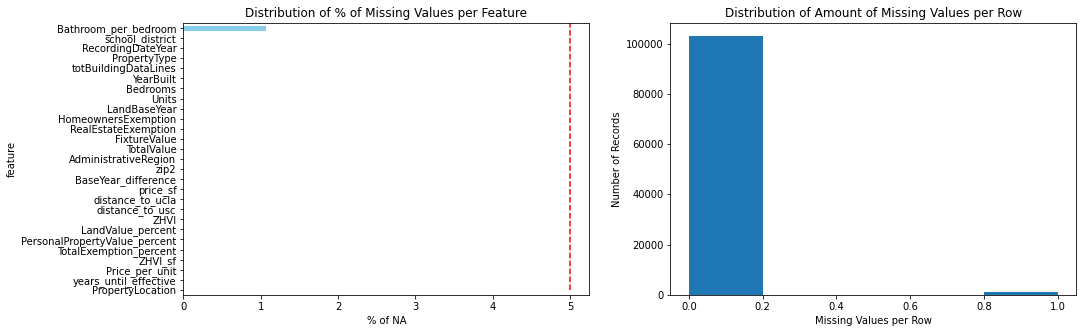

In [12]:
## TO DO: Assess missing values by columns and rows
plot_NA(df, benchmark=5, bins=5)

In [61]:
## TO DO: fill missing values (NAs or inf) with -1
df['Bathroom_per_bedroom'].fillna(value=-1, inplace=True)
df['Bathroom_per_bedroom'][df.Bathroom_per_bedroom == np.inf] = -1
df['Price_per_unit'][df.Price_per_unit == np.inf] = -1

Obviously, the NAs in *Bathroom_per_bedroom* and *Price_per_unit* due to zero denominator. Rather than simply remove those properties, here we mark those missing values specially as -1 to avoid introducing any bias or losing information.

In [14]:
df = df.drop('NA_this_row', axis=1)

### Handle Outliers

In [62]:
## TO DO: detect outliers through extreme values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
totBuildingDataLines,104136.0,1.119891e+00,3.922248e-01,1.000000,1.000000,1.000000e+00,1.000000e+00,5.000000e+00
YearBuilt,104136.0,1.947585e+03,3.399625e+01,1900.000000,1920.000000,1.939000e+03,1.974000e+03,2.020000e+03
Bedrooms,104136.0,4.015605e+00,6.365648e+00,0.000000,2.000000,3.000000e+00,4.000000e+00,3.050000e+02
Units,104136.0,2.537864e+00,1.006188e+01,0.000000,1.000000,1.000000e+00,2.000000e+00,9.130000e+02
LandBaseYear,104136.0,2.002948e+03,1.410538e+01,1975.000000,1994.000000,2.006000e+03,2.015000e+03,2.021000e+03
HomeownersExemption,104136.0,2.648048e+03,3.414299e+03,0.000000,0.000000,0.000000e+00,7.000000e+03,2.100000e+04
RealEstateExemption,104136.0,1.881127e+04,5.543372e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,1.033927e+08
FixtureValue,104136.0,6.940782e+01,1.014669e+04,0.000000,0.000000,0.000000e+00,0.000000e+00,2.379300e+06
TotalValue,104136.0,1.171790e+06,5.795106e+06,9.000000,255386.750000,5.060920e+05,9.800540e+05,8.259572e+08
AdministrativeRegion,104136.0,8.809854e+00,2.822057e+00,7.000000,7.000000,9.000000e+00,9.000000e+00,2.800000e+01


In [63]:
# TO DO: identify outliers as data point that falls outside of 3 standard deviations
def replace_outliers_z_score(dataframe, column, Z=3):
    from scipy.stats import zscore
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    
    # Replace with mean values
    no_outliers = dataframe[column].isnull().sum()
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
    
    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")

In [64]:
## TO DO: replace potential outliers with mean
cat_cols = df.select_dtypes(['int','float']).columns.values
i = 1
for col in cat_cols:
    df = replace_outliers_z_score(df,col)

Replaced: 0  outliers in  HomeownersExemption
Replaced: 0  outliers in  RealEstateExemption
Replaced: 0  outliers in  FixtureValue
Replaced: 0  outliers in  TotalValue
Replaced: 0  outliers in  zip2
Replaced: 0  outliers in  price_sf
Replaced: 0  outliers in  distance_to_ucla
Replaced: 0  outliers in  distance_to_usc
Replaced: 0  outliers in  LandValue_percent
Replaced: 0  outliers in  PersonalPropertyValue_percent
Replaced: 0  outliers in  TotalExemption_percent
Replaced: 0  outliers in  ZHVI_sf
Replaced: 0  outliers in  Bathroom_per_bedroom
Replaced: 0  outliers in  Price_per_unit


## EDA

In [65]:
## TO DO: correct feature types
df.zip2 = df.zip2.astype('int')
df.zip2 = df.zip2.astype('object')
df.YearBuilt = df.YearBuilt.astype('object')
df.AdministrativeRegion = df.AdministrativeRegion.astype('object')
df.PropertyType = df.PropertyType.astype('object')

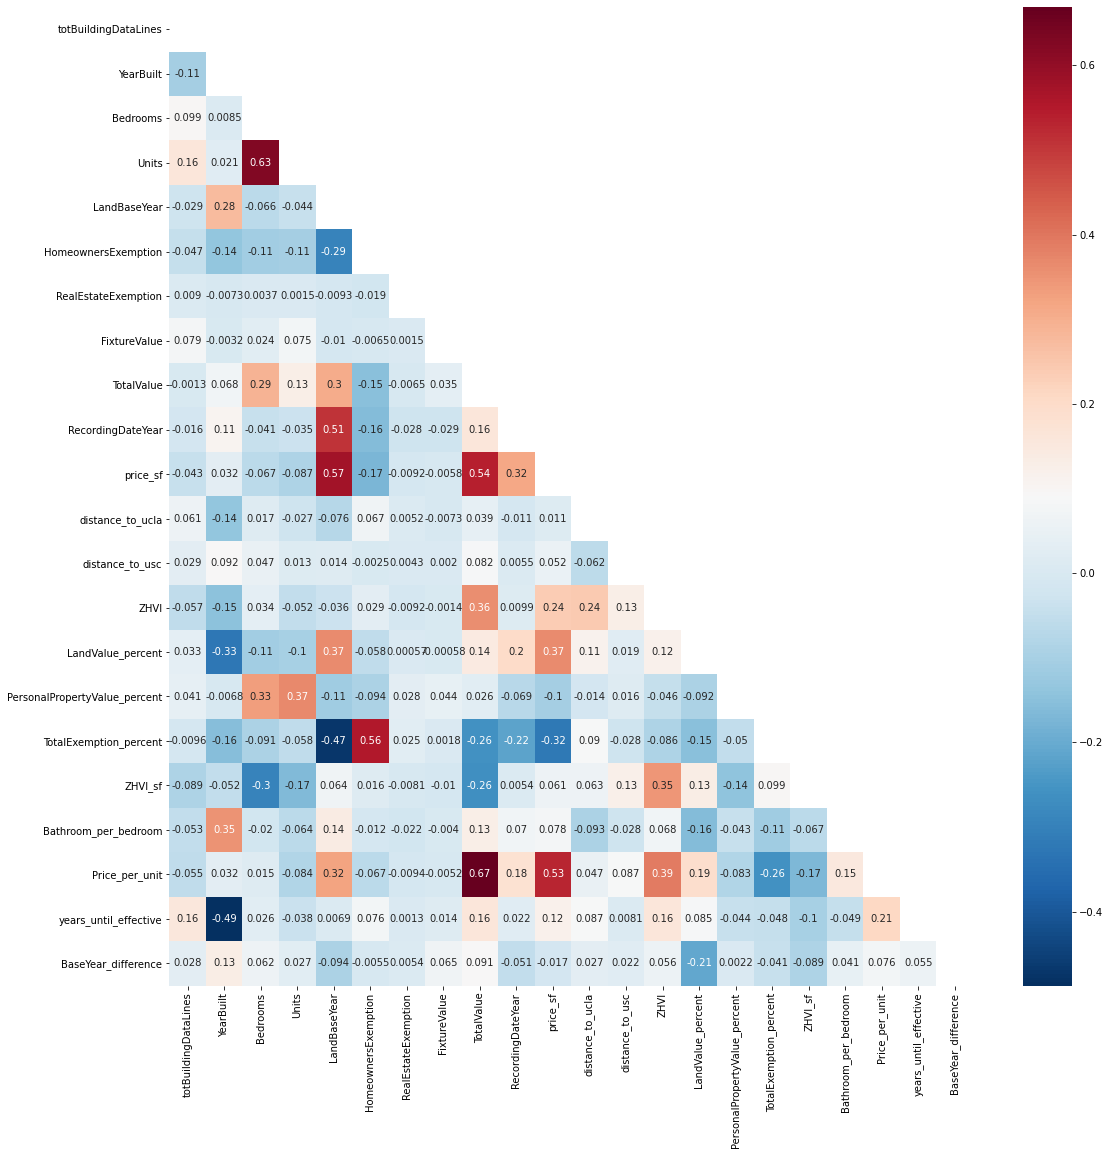

In [19]:
# TO DO: Calculate correlation of features for UCLA district
correlation = df[df.school_district=='ucla'].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Plot correlation
plt.figure(figsize=(18,18))
sns.heatmap(correlation, mask=mask, cmap="RdBu_r",xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

All of the correlation coefficients are less than 0.95, no significant multicolinearity.

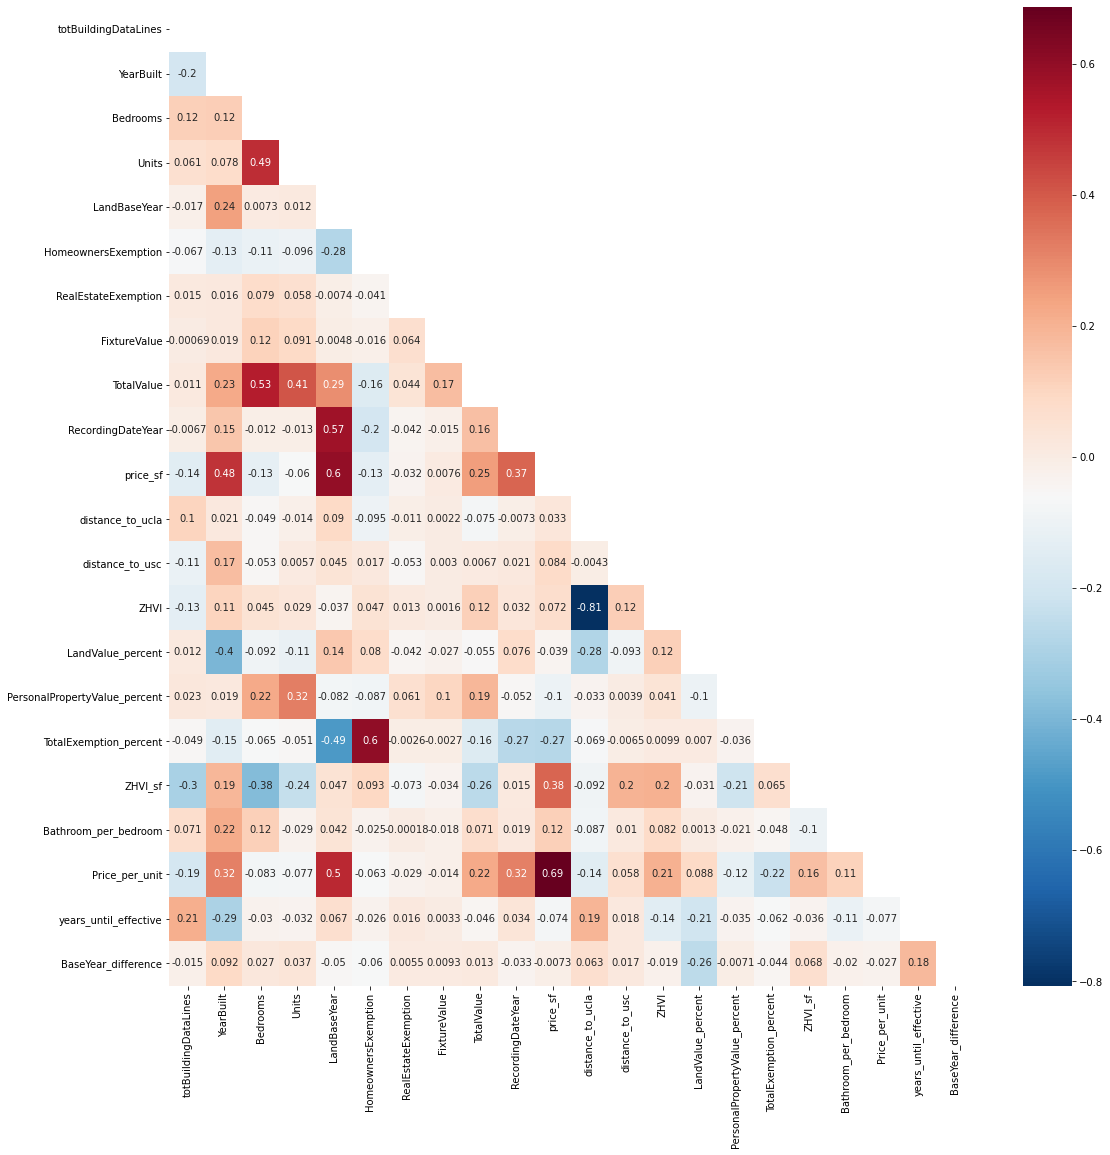

In [20]:
# TO DO: Calculate correlation of features for USC district
correlation = df[df.school_district=='usc'].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Plot correlation
plt.figure(figsize=(18,18))
sns.heatmap(correlation, mask=mask, cmap="RdBu_r",xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

All of the correlation coefficients are less than 0.95, no significant multicolinearity.

In [66]:
# TO DO: remove geographic identifier for EDA
df_clean = df.drop('PropertyLocation',axis=1)

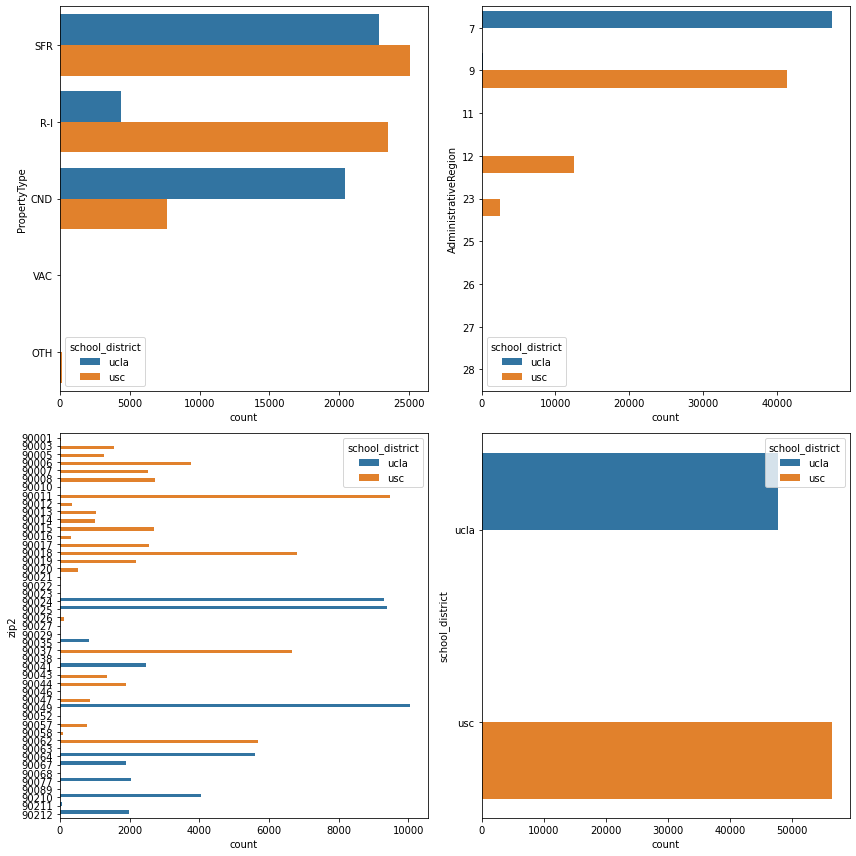

In [22]:
# TO DO: plot categorical features
plt.figure(figsize=(12, 12))
cat_cols = df_clean.select_dtypes(['object']).columns.values
i = 1
for col in cat_cols:
    plt.subplot(2, 2, i)
    sns.countplot(y=df_clean[col],hue='school_district',data=df_clean)
    plt.xticks()
    plt.tick_params(labelbottom=True)
    i += 1
plt.tight_layout()

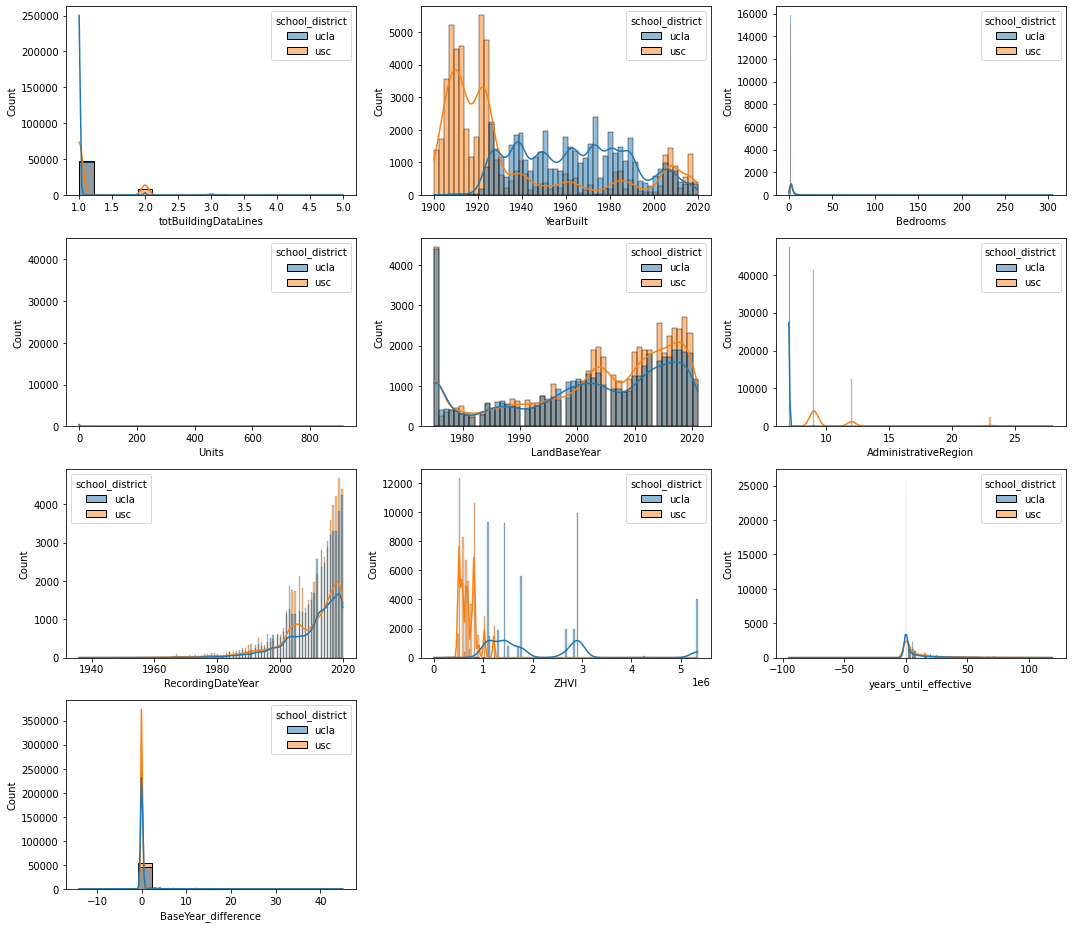

In [292]:
# TO DO: plot numerical features
plt.figure(figsize=(15, 13))
cat_cols = df_clean.select_dtypes(['int64']).columns.values
i = 1
for col in cat_cols:
    plt.subplot(4, 3, i)
    sns.histplot(x=df_clean[col],kde=True, hue='school_district',data=df_clean)
    #res = stats.probplot(df_clean[col], plot=plt)
    #sns.boxplot(y=df_clean['price_sf'],x=col, data=df_clean ,color='green')
    plt.xticks(rotation=0)
    plt.tick_params()
    i += 1
plt.tight_layout()

YearBuilt shows distinct pattern, properties in UCLA district are younger than those in USC district overall. UCLA district shows higher ZHVI.

<Figure size 720x720 with 0 Axes>

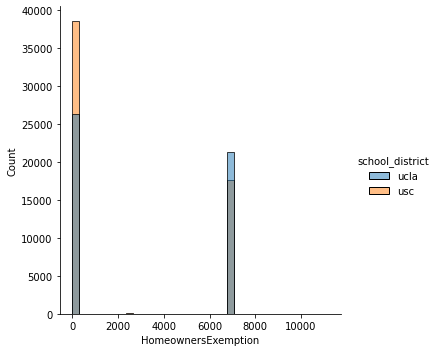

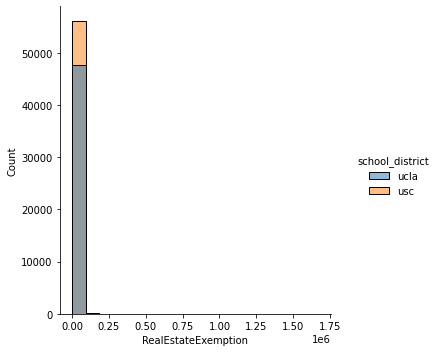

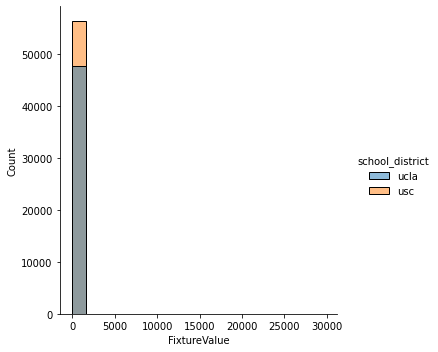

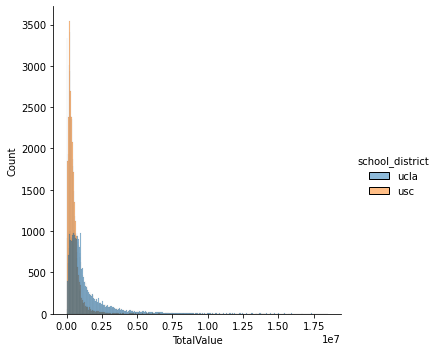

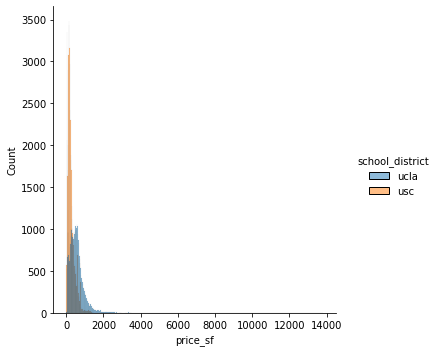

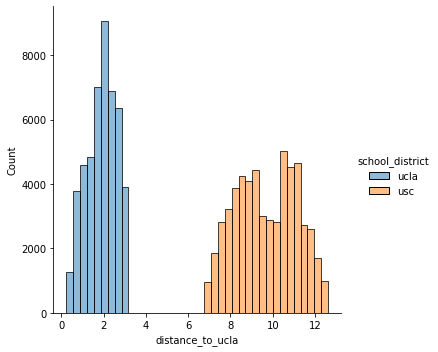

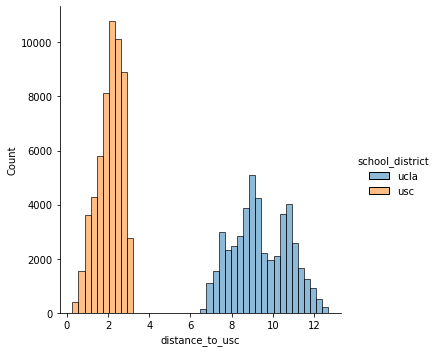

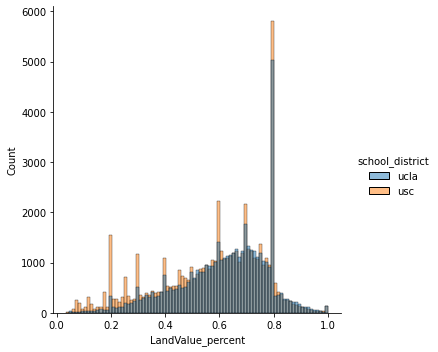

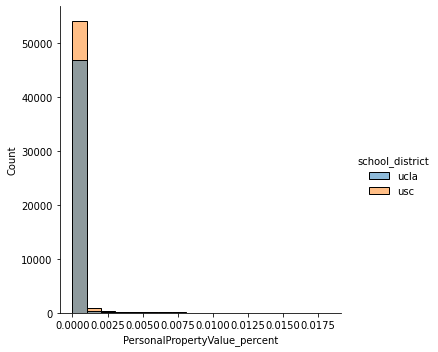

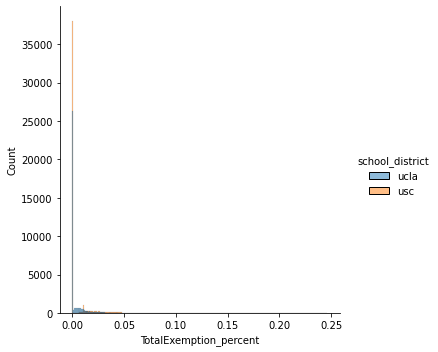

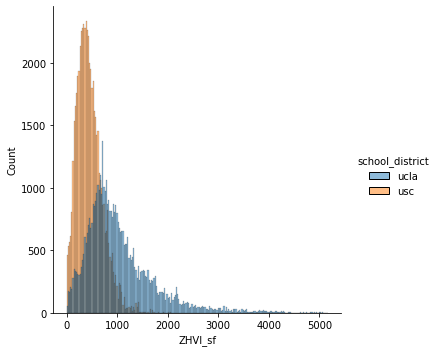

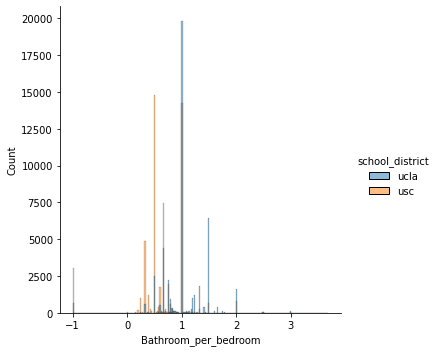

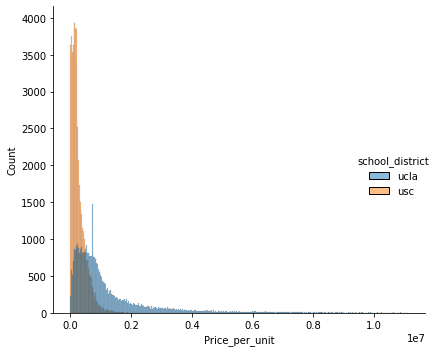

In [38]:
# TO DO: plot numerical float features
plt.figure(figsize=(10, 10))
cat_cols = df_clean.select_dtypes(['float']).columns.values
i = 1
for col in cat_cols:
    #plt.subplot(4, 4, i)
    sns.displot(x=df_clean[col], hue='school_district',data=df_clean)
    #res = stats.probplot(df_clean[col], plot=plt)
    #sns.boxplot(y=df_clean['price_sf'],x=col, data=df_clean ,color='green')
    plt.xticks(rotation=0)
    plt.tick_params()
    i += 1
plt.tight_layout()

In [67]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104136 entries, 0 to 104232
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PropertyType                   104136 non-null  object 
 1   totBuildingDataLines           104136 non-null  int64  
 2   YearBuilt                      104136 non-null  object 
 3   Bedrooms                       104136 non-null  int64  
 4   Units                          104136 non-null  int64  
 5   LandBaseYear                   104136 non-null  int64  
 6   HomeownersExemption            104136 non-null  float64
 7   RealEstateExemption            104136 non-null  float64
 8   FixtureValue                   104136 non-null  float64
 9   TotalValue                     104136 non-null  float64
 10  AdministrativeRegion           104136 non-null  object 
 11  RecordingDateYear              104136 non-null  int64  
 12  zip2                          

## Feature Engineering

### One-hot Encoding

In [68]:
df_clean.head().T

,0,1,2,3,4
PropertyType,SFR,R-I,R-I,R-I,R-I
totBuildingDataLines,2,1,2,1,1
YearBuilt,2018,2017,1937,2016,1960
Bedrooms,8,57,2,21,10
Units,2,19,2,9,6
LandBaseYear,2016,2014,2018,2014,2018
HomeownersExemption,0.0,0.0,0.0,0.0,0.0
RealEstateExemption,0.0,0.0,0.0,0.0,0.0
FixtureValue,0.0,0.0,0.0,0.0,0.0
TotalValue,2542900.0,7291992.0,2679250.0,4860906.0,4214410.0


In [69]:
# TO DO: drop some multivariate features for computational simplicity
df_clean = df_clean.drop(['LandBaseYear', 'RecordingDateYear'],axis=1)

In [70]:
## TO DO: separate the one-hot dataset for two schools
df_ucla = df_clean[df_clean.school_district == 'ucla']
df_ucla = df_ucla.drop('school_district',axis=1)


df_usc = df_clean[df_clean.school_district == 'usc']
df_usc = df_usc.drop('school_district',axis=1)

In [71]:
# TO DO: Create dummy variables for ucla
cat1 = pd.get_dummies(df_ucla.zip2, prefix = "zip")
cat2 = pd.get_dummies(df_ucla.AdministrativeRegion, prefix = "Region")
cat3 = pd.get_dummies(df_ucla.PropertyType, prefix = "PropertyType")
cat4 = pd.get_dummies(df_ucla.YearBuilt, prefix = "YearBuilt")
#cat5 = pd.get_dummies(df_clean.LandBaseYear, prefix = "LandBaseYear")
#cat6 = pd.get_dummies(df_clean.RecordingDateYear, prefix = "RecordingDateYear")

In [72]:
# TO DO: Merge dummy variables to main dataframe
ucla_hot = pd.concat([df_ucla,cat1], axis=1)
ucla_hot = pd.concat([ucla_hot,cat2], axis=1)
ucla_hot = pd.concat([ucla_hot,cat3], axis=1)
ucla_hot = pd.concat([ucla_hot,cat4], axis=1)
#df_hot = pd.concat([df_hot,cat5], axis=1)
#df_hot = pd.concat([df_hot,cat6], axis=1)

In [73]:
# TO DO: Correct the data type
for cat in [cat1,cat2, cat3, cat4]:
    cat_cols = cat.columns
    for col in cat_cols:
        ucla_hot[col] = ucla_hot[col].astype("category")

In [74]:
# TO DO: drop original features
ucla_hot = ucla_hot.drop(["zip2","PropertyType","YearBuilt","zip_90057"], axis=1)

In [75]:
ucla_hot.head().T

,0,1,2,3,4
totBuildingDataLines,2,1,2,1,1
Bedrooms,8,57,2,21,10
Units,2,19,2,9,6
HomeownersExemption,0.0,0.0,0.0,0.0,0.0
RealEstateExemption,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
YearBuilt_2016,0,0,0,1,0
YearBuilt_2017,0,1,0,0,0
YearBuilt_2018,1,0,0,0,0
YearBuilt_2019,0,0,0,0,0


In [76]:
# TO DO: Create dummy variables for ucla
cat1 = pd.get_dummies(df_usc.zip2, prefix = "zip")
cat2 = pd.get_dummies(df_usc.AdministrativeRegion, prefix = "Region")
cat3 = pd.get_dummies(df_usc.PropertyType, prefix = "PropertyType")
cat4 = pd.get_dummies(df_usc.YearBuilt, prefix = "YearBuilt")
#cat5 = pd.get_dummies(df_clean.LandBaseYear, prefix = "LandBaseYear")
#cat6 = pd.get_dummies(df_clean.RecordingDateYear, prefix = "RecordingDateYear")

In [77]:
# TO DO: Merge dummy variables to main dataframe
usc_hot = pd.concat([df_usc,cat1], axis=1)
usc_hot = pd.concat([usc_hot,cat2], axis=1)
usc_hot = pd.concat([usc_hot,cat3], axis=1)
usc_hot = pd.concat([usc_hot,cat4], axis=1)
#df_hot = pd.concat([df_hot,cat5], axis=1)
#df_hot = pd.concat([df_hot,cat6], axis=1)

In [78]:
# TO DO: Correct the data type
for cat in [cat1,cat2, cat3, cat4]:
    cat_cols = cat.columns
    for col in cat_cols:
        usc_hot[col] = usc_hot[col].astype("category")

In [79]:
# TO DO: drop original features
usc_hot = usc_hot.drop(["zip2","PropertyType","YearBuilt","zip_90023", "zip_90063"], axis=1)

In [80]:
usc_hot.head().T

,47720,47721,47722,47723,47724
totBuildingDataLines,1,2,2,1,1
Bedrooms,2,19,3,2,2
Units,1,4,2,1,1
HomeownersExemption,0.0,0.0,0.0,0.0,0.0
RealEstateExemption,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
YearBuilt_2016,0,0,0,0,0
YearBuilt_2017,0,0,0,0,0
YearBuilt_2018,0,0,0,0,0
YearBuilt_2019,0,1,0,0,0


### Data Scaling

for ucla

In [81]:
# TO DO: split the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_ucla = ucla_hot.drop(['price_sf'], axis = 1)
y_ucla = ucla_hot['price_sf']
X_train, X_test, y_train, y_test = train_test_split(X_ucla, y_ucla, test_size = 0.2, random_state = 99)

In [82]:
# TO DO: separate numerical and categorical features
X_train_num = X_train.select_dtypes(['int','float'])
X_train_cat = X_train.select_dtypes(['category'])

X_test_num = X_test.select_dtypes(['int','float'])
X_test_cat = X_test.select_dtypes(['category'])

In [83]:
# TO DO: standardize the data for UCLA
from sklearn.preprocessing import StandardScaler
scaler_ucla = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler_ucla.fit_transform(X_train_num))
X_train_num_scaled.columns = X_train_num.columns
X_train_num_scaled.index = X_train_num.index

X_test_num_scaled = pd.DataFrame(scaler_ucla.transform(X_test_num))
X_test_num_scaled.columns = X_test_num.columns
X_test_num_scaled.index = X_test_num.index

In [84]:
# TO DO: combine the scaled the part with categorical features
X_train_ucla_scaled = pd.concat([X_train_num_scaled,X_train_cat.sort_index()], axis=1)
X_test_ucla_scaled = pd.concat([X_test_num_scaled,X_test_cat.sort_index()], axis=1)

In [85]:
# TO DO: scale the target
scaler_y_ucla = StandardScaler()
y_train_ucla_scaled = scaler_y_ucla.fit_transform(y_train.values.reshape(-1, 1))
y_test_ucla_scaled = scaler_y_ucla.transform(y_test.values.reshape(-1, 1))

for usc

In [86]:
# TO DO: split the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_usc = usc_hot.drop(['price_sf'], axis = 1)
y_usc = usc_hot['price_sf']
X_train, X_test, y_train, y_test = train_test_split(X_usc, y_usc, test_size = 0.2, random_state = 99)

In [87]:
# TO DO: separate numerical and categorical features
X_train_num = X_train.select_dtypes(['int','float'])
X_train_cat = X_train.select_dtypes(['category'])

X_test_num = X_test.select_dtypes(['int','float'])
X_test_cat = X_test.select_dtypes(['category'])

In [88]:
# TO DO: standardize the data for USC
from sklearn.preprocessing import StandardScaler
scaler_usc = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler_usc.fit_transform(X_train_num))
X_train_num_scaled.columns = X_train_num.columns
X_train_num_scaled.index = X_train_num.index

X_test_num_scaled = pd.DataFrame(scaler_usc.transform(X_test_num))
X_test_num_scaled.columns = X_test_num.columns
X_test_num_scaled.index = X_test_num.index

In [89]:
# TO DO: combine the scaled the part with categorical features
X_train_usc_scaled = pd.concat([X_train_num_scaled,X_train_cat.sort_index()], axis=1)
X_test_usc_scaled = pd.concat([X_test_num_scaled,X_test_cat.sort_index()], axis=1)

In [90]:
# TO DO: scale the target
scaler_y_usc = StandardScaler()
y_train_usc_scaled = scaler_y_usc.fit_transform(y_train.values.reshape(-1, 1))
y_test_usc_scaled = scaler_y_usc.transform(y_test.values.reshape(-1, 1))

### Output for Modelling

In [93]:
X_train_ucla_scaled.to_csv('X_train_ucla.csv')
X_test_ucla_scaled.to_csv('X_test_ucla.csv')

In [94]:
pd.DataFrame(y_train_ucla_scaled).to_csv('y_train_ucla.csv')
pd.DataFrame(y_test_ucla_scaled).to_csv('y_test_ucla.csv')

In [95]:
X_train_usc_scaled.to_csv('X_train_usc.csv')
X_test_usc_scaled.to_csv('X_test_usc.csv')

In [96]:
pd.DataFrame(y_train_usc_scaled).to_csv('y_train_usc.csv')
pd.DataFrame(y_test_usc_scaled).to_csv('y_test_usc.csv')

## Results Analysis (after modelling)

for ucla

In [184]:
# TO DO: import predicted results of our best model
y_pred_ucla = pd.read_csv('y_pred_svr_ucla.csv')
y_pred_ucla = y_pred_ucla.drop('Unnamed: 0',axis=1)

y_pred_usc = pd.read_csv('y_pred_svr_usc.csv')
y_pred_usc = y_pred_usc.drop('Unnamed: 0',axis=1)

In [186]:
# TO DO: transfrom back to price_sf
y_pred_ucla = pd.DataFrame(scaler_y_ucla.inverse_transform(y_pred_ucla))
y_pred_ucla.index = X_test_ucla_scaled.index

y_pred_usc = pd.DataFrame(scaler_y_usc.inverse_transform(y_pred_usc))
y_pred_usc.index = X_test_usc_scaled.index

In [187]:
# TO DO: obtain the full properties info
fullset = df[['PropertyLocation','price_sf']]

In [361]:
# TO DO: obtain the expected value of the SE model for ucla
scaler_y_ucla.inverse_transform(np.zeros((9541, 1)))[0]

array([553.42535789])

In [363]:
# TO DO: combine ucla price outputs with property Location
ucla_result = pd.merge(fullset,y_pred_ucla,left_index=True,right_index=True)
ucla_result = ucla_result.rename(columns={0:'price_hat'})

# TO DO: naive adjustment
ucla_result['price_hat_adjusted'] = (ucla_result['price_hat'] - ucla_result['price_sf'] )*3 # naive adjustment
ucla_opp = ucla_result[ucla_result.price_hat_adjusted >= 553].sort_values('price_hat_adjusted')
ucla_opp

,PropertyLocation,price_sf,price_hat,price_hat_adjusted
34171,"10535 WILSHIRE BLVD, NO 1809 LOS ANGELES CA ...",298.076287,482.435228,553.076825
8704,"1800 BUTLER AVE, NO 105 LOS ANGELES CA 90025",291.164025,475.544336,553.140934
27303,"2417 34TH ST, 21 SANTA MONICA CA 90405",288.734340,473.237454,553.509343
37762,"10126 EMPYREAN WAY, NO 102 LOS ANGELES CA 90067",319.683340,504.268527,553.755562
12755,"10315 MISSOURI AVE, NO 103 LOS ANGELES CA 90025",313.501571,498.195054,554.080448
...,...,...,...,...
29025,1617 GLENDON AVE LOS ANGELES CA 90024,42.634166,523.488360,1442.562583
32563,10548 EASTBORNE AVE LOS ANGELES CA 90024,43.879118,529.791884,1457.738298
28681,1611 GLENDON AVE LOS ANGELES CA 90024,37.351961,523.577654,1458.677078
27452,1465 REEVES ST LOS ANGELES CA 90035,35.350950,522.227861,1460.630731


In [365]:
# TO DO: calculate opportunities density
len(ucla_opp)/len(ucla_result)

0.2827795828529504

for USC

In [360]:
# TO DO: obtain the expected value of the SE model for usc
scaler_y_usc.inverse_transform(np.zeros((9541, 1)))[0]

array([242.23264562])

In [366]:
# TO DO: combine usc price outputs with property Location
usc_result = pd.merge(fullset,y_pred_usc,left_index=True,right_index=True)
usc_result = usc_result.rename(columns={0:'price_hat'})

# TO DO: naive adjustment
usc_result['price_hat_adjusted'] = (usc_result['price_hat'] - usc_result['price_sf'] )*3
usc_opp = usc_result[usc_result.price_hat_adjusted>242].sort_values('price_hat_adjusted')
usc_opp

,PropertyLocation,price_sf,price_hat,price_hat_adjusted
56591,818 E ADAMS BLVD LOS ANGELES CA 90011,109.094752,189.803130,242.125133
56264,2819 MAPLE AVE LOS ANGELES CA 90011,115.565217,196.280682,242.146393
64292,1225 W 39TH PL LOS ANGELES CA 90037,96.174214,176.924036,242.249465
59769,600 W 58TH ST LOS ANGELES CA 90037,96.121905,177.037303,242.746196
52519,154 E 48TH ST LOS ANGELES CA 90011,108.181869,189.205171,243.069906
...,...,...,...,...
104178,601 W 40TH PL LOS ANGELES CA 90037,2.568347,190.794105,564.677277
69920,1941 W 39TH PL LOS ANGELES CA 90062,17.667268,205.997836,564.991704
71370,1420 W 38TH ST LOS ANGELES CA 90062,14.917360,205.963160,573.137402
88216,1609 W 24TH ST LOS ANGELES CA 90007,10.556389,202.864275,576.923658


In [367]:
# TO DO: calculate opportunities density
len(usc_opp)/len(usc_result)

0.22246832639319572

In [362]:
# TO DO: opportunities exploration
# ucla_result[ucla_result.price_hat_adjusted>700][ucla_result['PropertyLocation'].str.find('SANTA ') != -1]